<a href="https://colab.research.google.com/github/Serurays/Brain_Stroke_Detection_PyTorch/blob/main/Brain_Stroke_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import os

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from glob import glob

In [2]:
# Getting the dataset from Kaggle - https://www.kaggle.com/datasets/buraktaci/mri-stroke
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d buraktaci/mri-stroke
!unzip mri-stroke.zip

 99% 153M/154M [00:02<00:00, 58.3MB/s]
100% 154M/154M [00:02<00:00, 69.7MB/s]
Archive:  mri-stroke.zip
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/1.JPG  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/10.JPG  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/100.JPG  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/1000.png  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/1001.png  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/1002.png  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/1003.png  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/1004.png  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/101.JPG  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/102.JPG  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/103.JPG  
  inflating: Acute Ischemic Stroke-Control/Acute Ischemic Stroke/104.J

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# **Data Preparation and Exploration**

First of all, we can see that we have two different filex extensions, "jpg" and "png" in the dataset, I decided to count these extensions, and take the one with more samples.

In [4]:
from collections import defaultdict

def count_file_extensions(directory_path: str) -> dict[str, int]:
    """Counts the occurrences of different file extensions in a directory."""
    extension_counts = defaultdict(int)
    for dirpath, _, filenames in os.walk(directory_path):
        for filename in filenames:
            _, extension = os.path.splitext(filename)
            extension_counts[extension.lower()] += 1
    return extension_counts

# Example usage
extension_counts = count_file_extensions("/content/Acute Ischemic Stroke-Control")
print(f"Number of PNG files: {extension_counts.get('.png', 0)}")
print(f"Number of JPG files: {extension_counts.get('.jpg', 0)}")

Number of PNG files: 1677
Number of JPG files: 333


So, we are taking the images with "png" extension. There is another problem, the dataset isn't split into training and test folders, now it's time to do that.

In [5]:
from pathlib import Path
import shutil
from typing import List


# Setup path to a data folder (replace with your actual data directory)
data_path = Path("data/")
mri_path = data_path / "acute_ischemic_stroke_control"
print(f"Data Path: {data_path}")
print(f"MRI Path: {mri_path}")

# Create train and test directories
train_path = mri_path / "train"
print(f"Train Path: {train_path}")
test_path = mri_path / "test"
print(f"Test Path: {test_path}")

# Create directories for stroke and no_stroke under train and test
train_stroke = train_path / "stroke"
print(f"Train Stroke Path: {train_stroke}")
train_no_stroke = train_path / "no_stroke"
print(f"Train No Stroke Path: {train_no_stroke}")
test_stroke = test_path / "stroke"
print(f"Test Stroke Path: {test_stroke}")
test_no_stroke = test_path / "no_stroke"
print(f"Test No Stroke Path: {test_no_stroke}")

train_stroke.mkdir(parents=True, exist_ok=True)
train_no_stroke.mkdir(parents=True, exist_ok=True)
test_stroke.mkdir(parents=True, exist_ok=True)
test_no_stroke.mkdir(parents=True, exist_ok=True)


def move_files(file_list: List[Path], destination: Path, prefix: str) -> None:
    """Moves files from source to destination directory, renaming them sequentially."""
    counter = 1
    for f in file_list:
      # Create new filename with prefix and counter
      new_filename = f"{prefix}_{counter}.png"
       # Construct new path with new filename
      new_path = destination / new_filename
      print(f"Moving file: {f} to {new_path}")
      shutil.move(f, new_path)
      counter += 1


def split_data(source_dir: Path, train_dir: Path, test_dir: Path, percentage: float, prefix: str) -> None:
    """Splits files into train and test sets."""
    # Get all the files with .png extension from the source directory as a list
    files = list(source_dir.glob("*.png"))

    print(f"Found {len(files)} files in {source_dir}")

    # Calculate the split index
    split_index = int(len(files) * percentage)

    # Split the files into train and test sets
    train_files = files[:split_index]
    test_files = files[split_index:]

    # Move files to train directory
    move_files(train_files, train_dir, prefix)

    # Move files to test directory
    move_files(test_files, test_dir, prefix)


# Set the percentage for training data (train-test-split)
train_percentage = 0.8

# Print some informative messages before splitting data
print("Data directories created:")
print(f"- Train: {train_path}")
print(f"- Test: {test_path}")

# Split the data
stroke_source_dir = Path("/content/Acute Ischemic Stroke-Control/Acute Ischemic Stroke")
split_data(stroke_source_dir, train_stroke, test_stroke, train_percentage, "stroke")

no_stroke_source_dir = Path("/content/Acute Ischemic Stroke-Control/Control")
split_data(no_stroke_source_dir, train_no_stroke, test_no_stroke, train_percentage, "no_stroke")

print("Data splitting completed.")

Data Path: data
MRI Path: data/acute_ischemic_stroke_control
Train Path: data/acute_ischemic_stroke_control/train
Test Path: data/acute_ischemic_stroke_control/test
Train Stroke Path: data/acute_ischemic_stroke_control/train/stroke
Train No Stroke Path: data/acute_ischemic_stroke_control/train/no_stroke
Test Stroke Path: data/acute_ischemic_stroke_control/test/stroke
Test No Stroke Path: data/acute_ischemic_stroke_control/test/no_stroke
Data directories created:
- Train: data/acute_ischemic_stroke_control/train
- Test: data/acute_ischemic_stroke_control/test
Found 799 files in /content/Acute Ischemic Stroke-Control/Acute Ischemic Stroke
Moving file: /content/Acute Ischemic Stroke-Control/Acute Ischemic Stroke/594.png to data/acute_ischemic_stroke_control/train/stroke/stroke_1.png
Moving file: /content/Acute Ischemic Stroke-Control/Acute Ischemic Stroke/274.png to data/acute_ischemic_stroke_control/train/stroke/stroke_2.png
Moving file: /content/Acute Ischemic Stroke-Control/Acute Ische

In [6]:
# Setup training and test directories.
train_dir = mri_path / "train"
test_dir = mri_path / "test"

train_dir, test_dir

(PosixPath('data/acute_ischemic_stroke_control/train'),
 PosixPath('data/acute_ischemic_stroke_control/test'))

# **Visualizing an image**

Random Image Path: data/acute_ischemic_stroke_control/train/no_stroke/no_stroke_168.png
Image Class: no_stroke
Image Height: 628
Image Width: 608


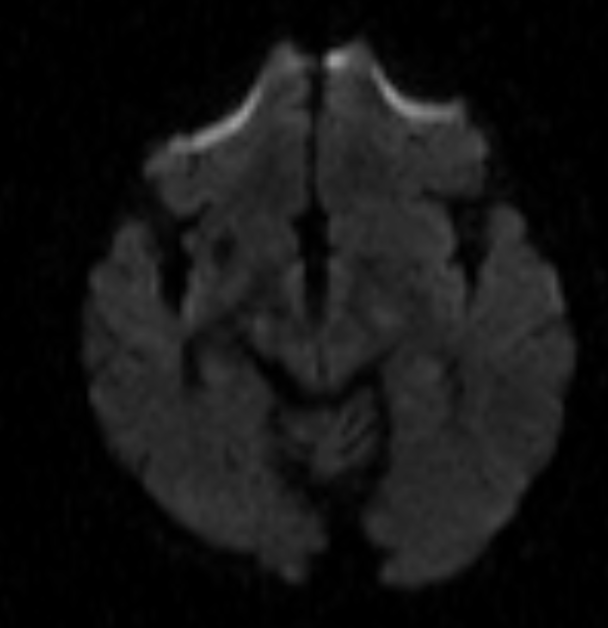

In [7]:
import random
from PIL import Image

# Get all image paths
image_path_list = list(mri_path.glob("*/*/*.png"))

# Pick a random image
random_img_path = random.choice(image_path_list)

# Get image class from path name (the image class is the name of the directory where the image is stored.)
image_class = random_img_path.parent.stem

# Open image
img = Image.open(random_img_path)

# Printing meta data
print(f"Random Image Path: {random_img_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

# **Transforming Data**

In [8]:
from torchvision import transforms

data_transform = transforms.Compose([
    # Resize the image to 224x224
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Convert to grayscale
    transforms.Grayscale(num_output_channels=1),
    # Convert to tensor (important to do before normalization)
    transforms.ToTensor()
])

In [9]:
def plot_transformed_image(image_path: list, transform, n=3, seed=None):
  """Plots original images and their transformed versions side by side."""
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_path, k=3)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nShape: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

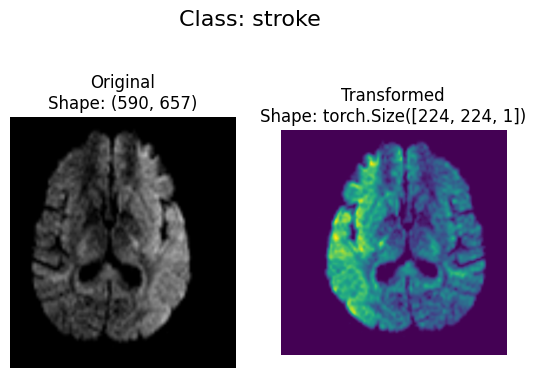

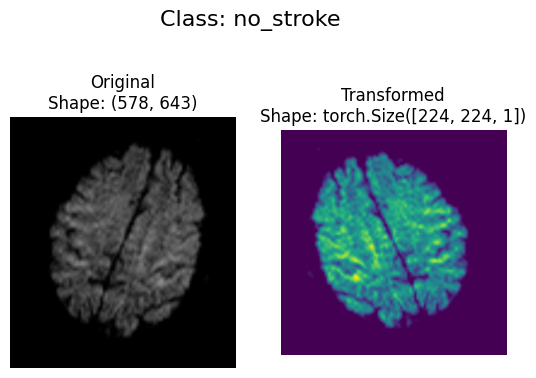

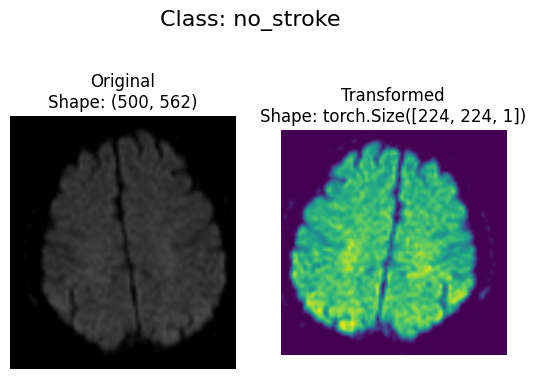

In [10]:
plot_transformed_image(image_path_list, data_transform)

In [11]:
# Load and transform data
from torchvision.datasets import ImageFolder

train_data = ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

In [12]:
# Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

# **Creating our Model (Transfer Learning)**

In [13]:
# class names
class_names = train_data.classes
class_names

['no_stroke', 'stroke']

In [14]:
# class_dict
class_dict = train_data.class_to_idx
class_dict

{'no_stroke': 0, 'stroke': 1}

In [26]:
import torch
from torch import nn


class StrokeClassifierCNN(nn.Module):
   def __init__(self):
       super(StrokeClassifierCNN, self).__init__()
       self.conv_block_1 = nn.Sequential(
           nn.Conv2d(1, 32, kernel_size=3, padding=1),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True),
           nn.Conv2d(32, 64, kernel_size=3, padding=1),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2, stride=2),
       )

       self.conv_block_2 = nn.Sequential(
           nn.Conv2d(64, 64, kernel_size=3, padding=1),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.Conv2d(64, 128, kernel_size=3, padding=1),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2, stride=2),
       )

       self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(128*56*56, 128),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.2),
           nn.Linear(128, 1)
       )

   def forward(self, x):
       # x = self.conv_block_1(x)
       # print(x.shape)
       # x = self.conv_block_2(x)
       # print(x.shape)
       # x = self.classifier(x)
       # print(x.shape)
       # return x
       return self.classifier(self.conv_block_2(self.conv_block_1(x)))

# Create an instance of the model
model = StrokeClassifierCNN()

In [27]:
# Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)  # Reduce LR on plateau

In [28]:
# Torchmetrics Accuracy
try:
  from torchmetrics.classification import Accuracy
except:
  !pip install -q torchmetrics -U
  from torchmetrics.classification import Accuracy

# Accuracy Function
accuracy_fn = Accuracy(task="binary").to(device)
accuracy_fn

BinaryAccuracy()

In [29]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 1, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
StrokeClassifierCNN                      [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─Conv2d: 2-4                       [1, 64, 224, 224]         18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 224, 224]         128
│    └─ReLU: 2-6                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-8                       [1, 64, 112, 112]         36,928
│    └─BatchNorm2d: 2-9                  [1, 64, 112, 112]         128
│    └─ReLU: 2-10                        [1, 64, 112, 112]         --
│   

In [30]:
def evaluate(model, dataloader, loss_fn, accuracy_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for batch, (X_test, y_test) in enumerate(dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            # Forward pass
            y_logit = model(X_test).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logit))

            # Calculate loss
            test_loss += loss_fn(y_logit, y_test.float()).item()

            # Calculate accuracy
            test_acc += accuracy_fn(y_test, y_pred)

    # Calculate average loss and accuracy
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    # Print evaluation stats
    print(f"\nVal Loss: {test_loss:.4f} | Val Accuracy: {test_acc:.4f}\n")
    return test_loss, test_acc

In [31]:
def train_loop(model, dataloader, loss_fn, optimizer, accuracy_fn, device, epochs=20, patience=5):
    model.train()
    best_val_acc = 0
    early_stopping_count = 0

    train_losses = []  # List to store training losses at each epoch
    train_accuracies = []  # List to store training accuracies at each epoch
    test_losses = []  # List to store testing losses at each epoch
    test_accuracies = []  # List to store testing accuracies at each epoch

    for epoch in range(epochs):
        train_loss, train_acc = 0, 0
        for batch, (X_train, y_train) in enumerate(dataloader):
            # Move data to device (GPU if available)
            X_train, y_train = X_train.to(device), y_train.to(device)

            # Forward pass
            y_logit = model(X_train).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logit))

            # Calculate the loss / accuracy
            loss = loss_fn(y_logit, y_train.float())
            train_loss += loss.item()
            train_acc += accuracy_fn(y_train, y_pred)

            # Optimizer zero grad
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

        # Calculate average loss and accuracy per epoch
        train_loss /= len(dataloader)
        train_acc /= len(dataloader)

        # Print training stats
        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

        # Evaluate on test set
        val_loss, val_acc = evaluate(model, test_dataloader, loss_fn, accuracy_fn, device)

        # Store the results for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(val_loss)
        test_accuracies.append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_count = 0
            torch.save(model.state_dict(), "best_model.pt")  # Save best model
        else:
            early_stopping_count += 1
            if early_stopping_count >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Update learning rate with scheduler
        scheduler.step(val_loss)

    # Return the training and testing losses and accuracies
    return train_losses, train_accuracies, test_losses, test_accuracies

In [32]:
# Test Loop

def test_loop(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = None
):
  # Test mode
  model.eval()

  # Test loss / accuracy
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(dataloader):
      # Put the tensors on device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass
      test_logit = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logit))

      # Calculate the loss / accuracy
      test_loss += loss_fn(test_logit, y_test.float())
      acc = accuracy_fn(y_test, test_pred)
      test_acc += acc

    # Average Loss and Accuracy per Batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [33]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          training_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          epochs: int = 5,
          device: torch.device = None):

  # Create empty dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_loop(model, training_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs)
    test_loss, test_acc = test_loop(model, test_dataloader, loss_fn, optimizer, accuracy_fn, device, epochs)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [34]:
# Set number of epochs
NUM_EPOCHS = 30

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, accuracy_fn, NUM_EPOCHS, device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30 | Train Loss: 0.8963 | Train Accuracy: 0.6577

Val Loss: 0.7081 | Val Accuracy: 0.5426

Epoch: 2/30 | Train Loss: 0.6065 | Train Accuracy: 0.6774

Val Loss: 0.5390 | Val Accuracy: 0.7102

Epoch: 3/30 | Train Loss: 0.5429 | Train Accuracy: 0.7186

Val Loss: 0.5237 | Val Accuracy: 0.7415

Epoch: 4/30 | Train Loss: 0.5113 | Train Accuracy: 0.7381

Val Loss: 0.4938 | Val Accuracy: 0.7812

Epoch: 5/30 | Train Loss: 0.4556 | Train Accuracy: 0.7867

Val Loss: 0.6919 | Val Accuracy: 0.6562

Epoch: 6/30 | Train Loss: 0.4780 | Train Accuracy: 0.7600

Val Loss: 0.4804 | Val Accuracy: 0.7443

Epoch: 7/30 | Train Loss: 0.4215 | Train Accuracy: 0.7962

Val Loss: 0.4200 | Val Accuracy: 0.7955

Epoch: 8/30 | Train Loss: 0.3879 | Train Accuracy: 0.8136

Val Loss: 0.4542 | Val Accuracy: 0.7898

Epoch: 9/30 | Train Loss: 0.3545 | Train Accuracy: 0.8397

Val Loss: 0.3777 | Val Accuracy: 0.8182

Epoch: 10/30 | Train Loss: 0.3371 | Train Accuracy: 0.8516

Val Loss: 0.4390 | Val Accuracy: 0.7869


ValueError: too many values to unpack (expected 2)

Making predictions...:   0%|          | 0/11 [00:00<?, ?it/s]

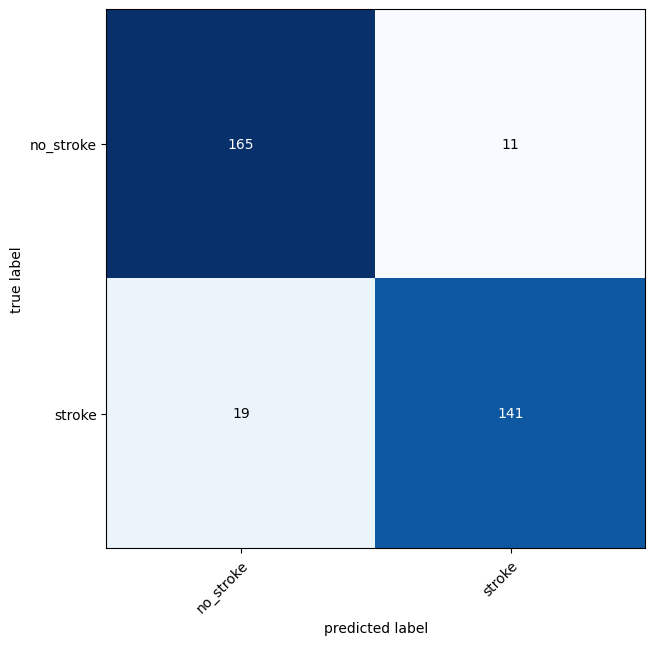

In [41]:
# Import tqdm.auto
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_logit = model(X).squeeze()
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.round(torch.sigmoid(y_logit))

    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="binary")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)